# Esto se corre con entorno Imaging, ademas necesitamos  aux_function.ipynb en la carpeta

Este primer paso del análisis toma la segmentación y parte de la metadata de los experimentos y lo compila en archivos pkls. Dentro de estos pkls hay objetos Area que tienen toda esta data, que vamos a ir completando en los siguientes pasos. 

In [1]:
# Importo librerías necesarias

from ipynb.fs.defs.aux_functions import *
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

c:\Users\PC\anaconda3\envs\imaging\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\PC\anaconda3\envs\imaging\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\PC\anaconda3\envs\imaging\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\PC\anaconda3\envs\imaging\lib\site-packages\tensorflow\python\frame

In [13]:
# Determino qué voy a procesar y de qué manera

# to_process = None #["3-1", "7-1", "17-1"] # cambiar a None si quiero procesar todo
# fish_interval = (0, 155)
# exp = "OLED-AUD-9"
# not_process = []

In [2]:
# Guardo los directorios que voy a usar (cambiar si estoy en otra compu o si cambio de lugar algo)

# drive_dir = r"G:\My Drive\Proyectos\Zebrafish Multisensory Integration/"
drive_dir = r"H:\My Drive\Valen Agulló\Habenula\Experimentos Violeta 2024"

#disk_dir = "D:/Nico/VIDEOS MICROSCOPIO/Microscopio confocal/"
disk_dir = r"C:\Users\PC\My Drive\Violeta"

#drive_dir = "L:/My Drive/Multimodal Integration/"
#disk_dir = "F:/Users/Nicolas/Desktop/REGISTROS CONFOCAL/"

data_dir = drive_dir + "Audiovisual Perception Optic Tectum - Confocal Calcium Imaging\Data"
# areas_dir = disk_dir + "resultados OLED AUD 9"
# video_dir = disk_dir + "registros/2023/OLED AUD 9"

areas_dir = disk_dir 
video_dir = disk_dir 

res_dir = areas_dir

# fish_interval = (130, 155)

In [3]:
# Cargo tabla de datos del microscopio y la convierto en objetos de tipo Trial con toda su información

os.chdir(disk_dir)

dataset = pd.read_excel("SoloVideosHabenulaAVsS1_2.xlsx")    
dataset_2 = pd.read_excel("Habenula.xlsx", sheet_name=0)
dataset_3 = pd.read_excel("Solo videos habenula 11_24.xlsx", sheet_name=0)
print(dataset.shape)

trials = load_dataset(dataset, verbose = False)

#Vemos en el dataset 
Pez_sin_dZ= list(set(dataset_2['animal'][dataset_2['desplazamientoZ']>3]))
print(len(Pez_sin_dZ[67:]), 112-67, f'{int(len(Pez_sin_dZ[67:])/(112-67)*100)}%')

(2200, 34)
29 45 64%


In [ ]:
# # Ordeno los trials en un diccionario que está separado por exp, fecha, pez, area 
# factors = ["Exp", "Fecha", "Pez", "Area_num"]
# sorted_t = sort_trials(trials, factors = factors, verbose = False)


In [4]:
#Selecciono trial con cierta región
for trial in trials:
    region_list = trial.region.split("+")

    trial.region_list = region_list


In [5]:
#Valen: Ubico en una carpeta todos los archivos con un sufijo dado y guardo nombre y ulr, después los levanto 
def listar_archivos(carpeta, sufijo):
    #Ubico en una carpeta todos los archivos con un sufijo dado y guardo nombre y ulr, después los levanto 
    archivos = []
    
    # Recorre todos los archivos en la carpeta especificada
    for archivo in os.listdir(carpeta):
        # Verifica si el archivo tiene el sufijo especificado
        if archivo.endswith(sufijo):
            # Guarda el nombre del archivo y su ruta completa
            ruta_completa = os.path.join(carpeta, archivo)
            archivos.append((archivo, ruta_completa))
    
    return archivos
#Valen: busca el archivo con el nombre que le das en todas las carpetas de la ruta base.
def buscar_archivo(nombre_archivo, ruta_base):
    # Recorremos todas las carpetas y archivos dentro de la ruta base
    for root, dirs, files in os.walk(ruta_base):
        # Si el archivo está en la lista de archivos en esta carpeta
        if nombre_archivo in files:
            # Retornamos la ruta completa al archivo
            return os.path.join(root, nombre_archivo)
    
    # Si no se encuentra, retornamos un mensaje indicando que no existe
    return f'Archivo {nombre_archivo} no encontrado en {ruta_base}'

# Definir el nombre del archivo y la ruta base

ruta_base = 'D:\\Videos Confocal Valen'


In [6]:
# Viejo orden: 
# # Ordeno los trials en un diccionario que está separado por exp, fecha, pez, area 
# factors = ["Exp", "Fecha", "Pez", "Area_num"]

# Ordeno los trials en un diccionario que está separado por pez, area 
factors = ["Pez", "Area_num"]
sorted_t = sort_trials(trials, factors = factors)

templados_ulr_do = listar_archivos(r'C:\Users\PC\Desktop\Mascaras templados', 'png')
templados_ulr = []
for i in templados_ulr_do:
    #Este if define que imagenes lñevanto, es decir que se puede tunear
    if 'Templado' in i[0] and '.png' in i[0]:
        templados_ulr.append(i)
# Ordenar la lista por el número presente en el primer elemento de cada tupla
templados_ulr = sorted(templados_ulr, key=lambda x: int(x[0].split('_')[0]))
templados_ulr_posta = []
Pez_a_ver = []
for i in templados_ulr:
    if int(i[0].split('_')[0]) in sorted_t.keys():
        Pez_a_ver.append(int(i[0].split('_')[0]))
        templados_ulr_posta.append(i)

Pez: 1 | Area_num: 1
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Pez: 2 | Area_num: 1
[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Pez: 4 | Area_num: 1
[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
Pez: 5 | Area_num: 1
[61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
Pez: 6 | Area_num: 1
[81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
Pez: 7 | Area_num: 1
[101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]
Pez: 8 | Area_num: 1
[121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140]
Pez: 9 | Area_num: 1
[141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160]
Pez: 10 | Area_num: 1
[161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180]
Pez: 11 |

In [7]:

areas = {}

for pez in sorted_t:
    #Si queremos levantar un grupo en particular de peces.
    if pez in Pez_a_ver and pez in Pez_sin_dZ:
        for area in sorted_t[pez]:
            print(pez)
            areas[str(pez) + "-" + str(area)] = Area(pez, area)
            areas[str(pez) + "-" + str(area)].set_trials(sorted_t[pez][area])


for key in areas:
    print(areas[key].to_string())

71
73
74
75
76
78
82
83
84
85
86
87
90
91
92
93
94
95
96
97
101
103
104
105
107
109
110
111
112
PEZ 71 | AREA 1 | 20 trials.
PEZ 73 | AREA 1 | 20 trials.
PEZ 74 | AREA 1 | 20 trials.
PEZ 75 | AREA 1 | 20 trials.
PEZ 76 | AREA 1 | 20 trials.
PEZ 78 | AREA 1 | 20 trials.
PEZ 82 | AREA 1 | 20 trials.
PEZ 83 | AREA 1 | 20 trials.
PEZ 84 | AREA 1 | 20 trials.
PEZ 85 | AREA 1 | 20 trials.
PEZ 86 | AREA 1 | 20 trials.
PEZ 87 | AREA 1 | 20 trials.
PEZ 90 | AREA 1 | 20 trials.
PEZ 91 | AREA 1 | 20 trials.
PEZ 92 | AREA 1 | 20 trials.
PEZ 93 | AREA 1 | 20 trials.
PEZ 94 | AREA 1 | 20 trials.
PEZ 95 | AREA 1 | 20 trials.
PEZ 96 | AREA 1 | 20 trials.
PEZ 97 | AREA 1 | 20 trials.
PEZ 101 | AREA 1 | 20 trials.
PEZ 103 | AREA 1 | 20 trials.
PEZ 104 | AREA 1 | 20 trials.
PEZ 105 | AREA 1 | 20 trials.
PEZ 107 | AREA 1 | 20 trials.
PEZ 109 | AREA 1 | 20 trials.
PEZ 110 | AREA 1 | 20 trials.
PEZ 111 | AREA 1 | 20 trials.
PEZ 112 | AREA 1 | 20 trials.


In [8]:

# templados_ulr = listar_archivos(r'C:\Users\PC\Desktop\Templados Violeta', 'png')
# templados_ulr_czi= listar_archivos(r'C:\Users\PC\Desktop\Templados Violeta', 'czi')
templados = {}
ulr_czi_dic ={} 
#Armo un dic con el pez y el templado, pongo así raro el orden para que coincida la lista con los templados. 
for j,arch in zip(Pez_a_ver,templados_ulr_posta) :
    templados[j]=cv2.imread(arch[1], cv2.IMREAD_GRAYSCALE)
    ulr_czi_dic[j]=buscar_archivo(arch[0][:-7]+'.czi', ruta_base)

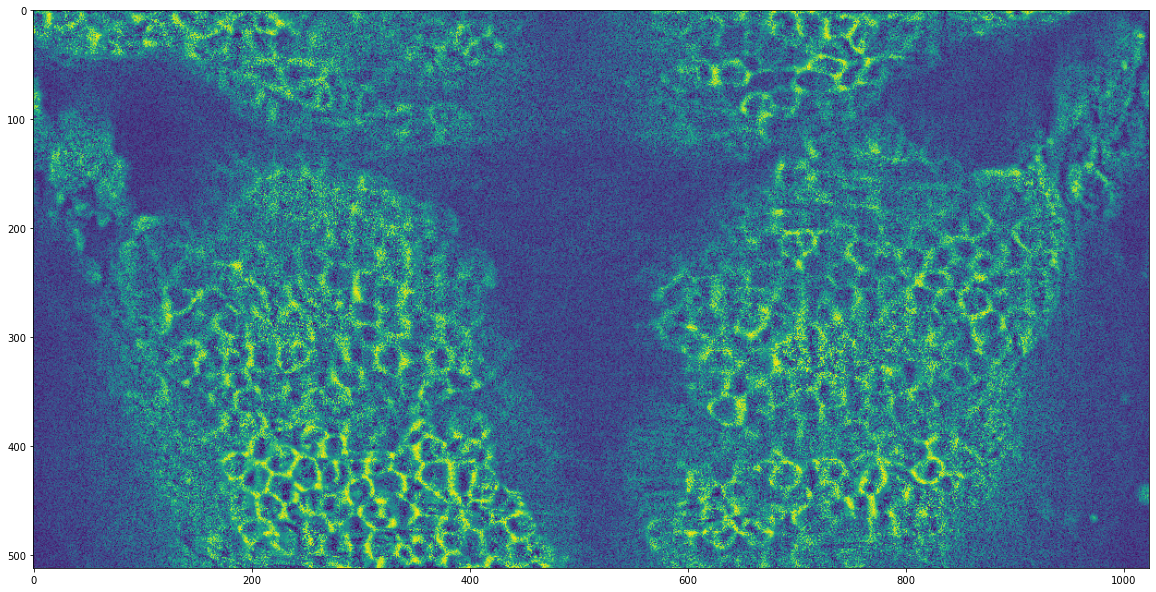

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(templados[71])

71-1 (512, 1024)


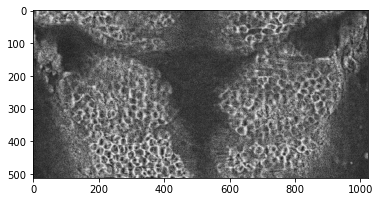

73-1 (512, 1024)


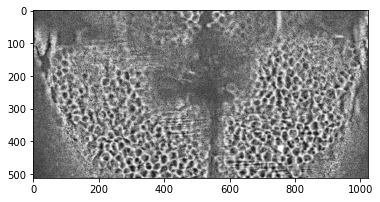

74-1 (512, 1024)


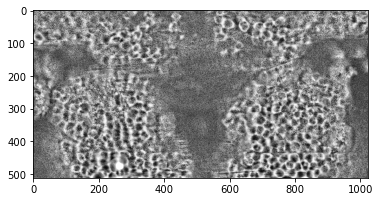

75-1 (512, 1024)


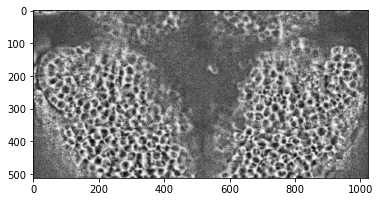

76-1 (512, 1024)


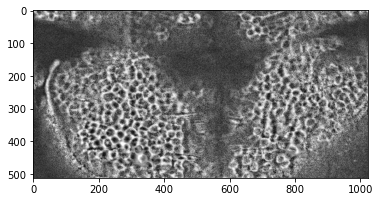

78-1 (512, 1024)


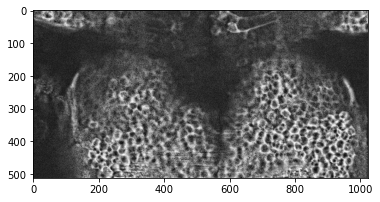

82-1 (512, 1024)


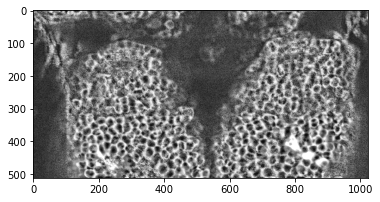

83-1 (512, 1024)


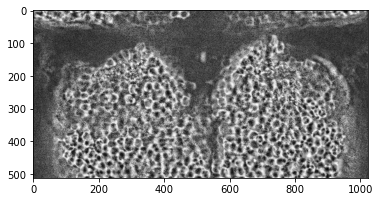

84-1 (512, 1024)


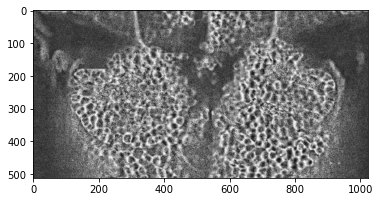

85-1 (512, 1024)


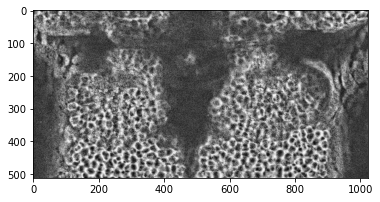

86-1 (512, 1024)


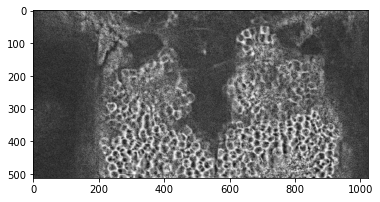

87-1 (512, 1024)


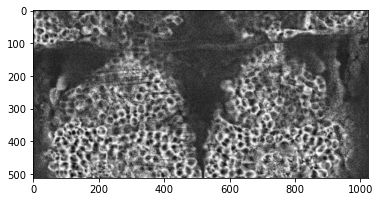

90-1 (512, 1024)


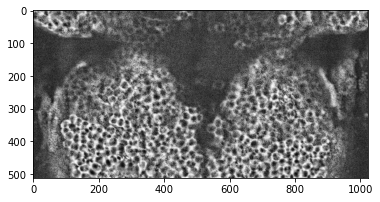

91-1 (512, 1024)


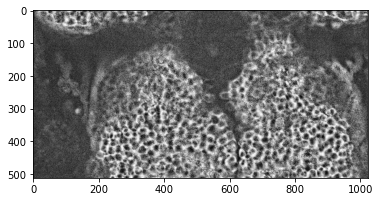

92-1 (512, 1024)


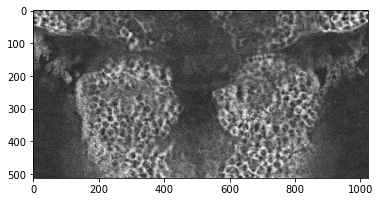

93-1 (512, 1024)


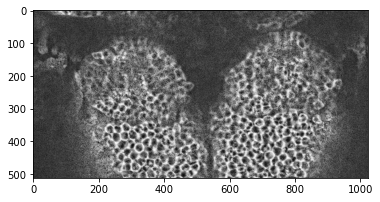

94-1 (512, 1024)


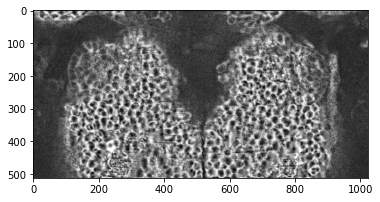

95-1 (512, 1024)


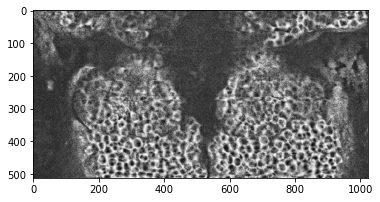

96-1 (512, 1024)


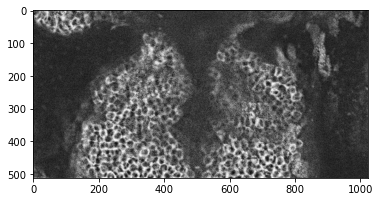

97-1 (512, 1024)


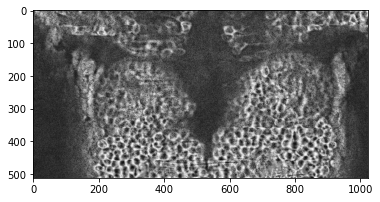

101-1 (512, 1024)


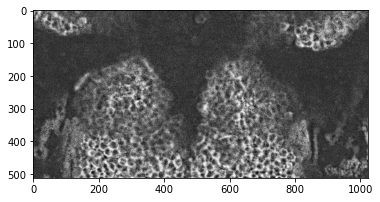

103-1 (512, 1024)


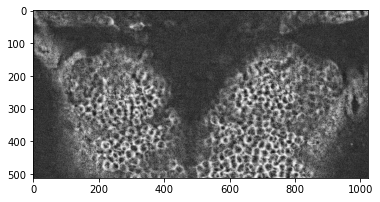

104-1 (512, 1024)


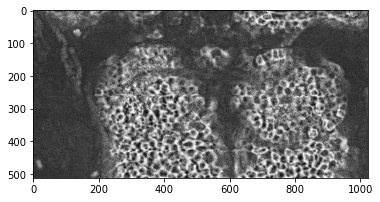

105-1 (512, 1024)


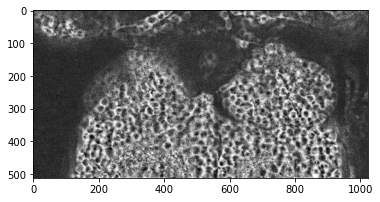

107-1 (512, 1024)


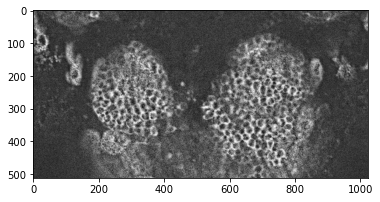

109-1 (512, 1024)


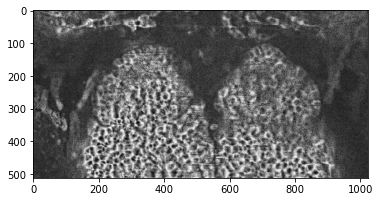

110-1 (512, 1024)


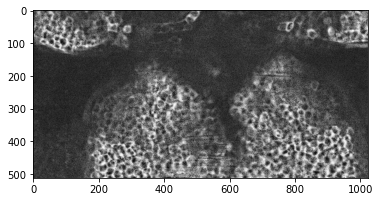

111-1 (512, 1024)


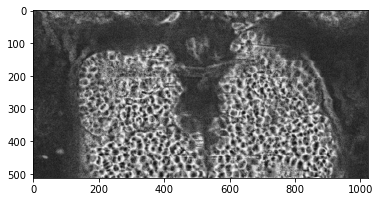

112-1 (512, 1024)


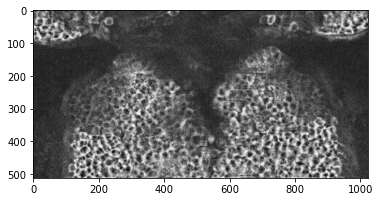

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


In [10]:
# Para cada área de cada pez, cargo su templado, si existe
# direc = 'C:\\Users\\PC\\Desktop\\Templados Violeta'
for key in list(areas.keys()):
    area = areas[key]

    # t = load_czi(direc, ulr_czi_dic[area.pez], file_type = "image")

    area.set_template(templados[area.pez], 4)

for key in areas:
    print(key, "None" if areas[key].template is None else areas[key].template.shape)
    plt.figure(figsize = (6,6))
    plt.imshow(areas[key].template, cmap = "gray")
    plt.show()


for key in areas:
    area = areas[key]
    print(area.factor)

In [12]:
for key in areas:
# for key in ['71-1']:
    print(areas[key].regions)
    polygons_per_area, midline_points, subtemplates, finished = define_sub_areas(areas[key].template, areas[key].regions)
    
    if not finished:
        break
    
    areas[key].set_polygons(polygons_per_area, subtemplates)

    areas[key].midline_points = midline_points
    

['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']
['Hb', 'palium']


In [13]:
new_areas = {}
for key in areas:
# for key in ['71-1']:
    if hasattr(areas[key], "midline_points"):
        new_areas[key] = areas[key]
        
areas = new_areas

print(areas.keys())

dict_keys(['71-1', '73-1', '74-1', '75-1', '76-1', '78-1', '82-1', '83-1', '84-1', '85-1', '86-1', '87-1', '90-1', '91-1', '92-1', '93-1', '94-1', '95-1', '96-1', '97-1', '101-1', '103-1', '104-1', '105-1', '107-1', '109-1', '110-1', '111-1', '112-1'])


In [19]:
def set_rois(area, grid, contours, centers):
    area.grids = {}
    area.contours = {}
    area.centers = {}

    area.contours_small = {}
    area.centers_small = {}

    contours = np.array(contours, dtype="object")

    for key in area.polygons_per_area_small:
        polygons = area.polygons_per_area_small[key]

        grid_centers = []

        for cell in grid:
            centerx = (cell[0] + cell[2])/2
            centery = (cell[1] + cell[3])/2

            grid_centers.append([centerx, centery])

        cells_in_area = np.zeros((len(grid_centers),)).astype('bool')

        for polygon in polygons:
            are_inside = points_in_polygon(grid_centers, polygon)
            cells_in_area = cells_in_area | are_inside

        area.grids[key] = grid[cells_in_area]


    for key in area.polygons_per_area:
        polygons = area.polygons_per_area[key]

        cells_in_area = np.zeros((len(centers),)).astype('bool')

        for polygon in polygons:
            are_inside = points_in_polygon(centers, polygon)
            cells_in_area = cells_in_area | are_inside

        area.centers[key] = centers[cells_in_area]
        area.contours[key] = contours[cells_in_area]
        
        area.centers_small[key] = (area.centers[key] / area.factor).astype('int')
        area.contours_small[key] = []
        for cnt in area.contours[key]:
            area.contours_small[key].append((cnt/area.factor).astype('int'))

In [20]:
from scipy.ndimage import center_of_mass
def closest_to_centroid(matrix, graf=False):
    """
    Encuentra el punto más cercano al centro geométrico de la región de True en una matriz booleana.
    
    Parámetros:
    matrix (numpy.ndarray): Matriz booleana de entrada.
    graf (bool): Si es True, grafica la matriz y los puntos. False por defecto.
    
    Retorna:
    tuple: Coordenadas del punto más cercano al centro geométrico (i, j).
    tuple: Coordenadas del centro geométrico (i, j).
    """
    # Calcular el centro de masa de la región True
    center_of_mass_coords = center_of_mass(matrix)
    # Convertir a coordenadas enteras para encontrar el punto más cercano
    center_of_mass_coords = np.round(center_of_mass_coords).astype(int)

    # Inicializar variables para almacenar la mínima distancia y el punto más cercano
    min_distance = np.inf
    closest_point = None

    # Recorrer la matriz para encontrar el punto True más cercano al centro de masa
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j]:
                # Calcular la distancia euclidiana
                distance = np.sqrt((i - center_of_mass_coords[0])**2 + (j - center_of_mass_coords[1])**2)
                if distance < min_distance:
                    min_distance = distance
                    closest_point = (i, j)

    # Si graf=True, graficar la matriz y el punto más cercano al centro geométrico
    if graf:
        plt.imshow(matrix, cmap='gray', origin='lower')
        plt.scatter(closest_point[1], closest_point[0], color='red', label='Punto más cercano',s=20, alpha=.5)
        plt.scatter(center_of_mass_coords[1], center_of_mass_coords[0], color='blue', label='Centro geométrico', s=1)
        plt.legend()
        plt.show()

    return closest_point, np.array(center_of_mass_coords)

def obtener_contorno(imagen):
    # np.where devuelve los índices donde la imagen tiene valor 1 (los contornos)
    y, x = np.where(imagen == 1)  # y son las filas, x son las columnas
    return np.array(list(zip(x, y)))  # Combina las coordenadas en pares (x, y)


In [21]:
for j,arch in zip(Pez_a_ver,templados_ulr) :
    templados[j]=cv2.imread(arch[1], cv2.IMREAD_GRAYSCALE)
    ulr_czi_dic[j]=buscar_archivo(arch[0][:-7]+'.czi', ruta_base)

In [ ]:
#Levantamos la segementación hecha con Cellpose, que está guardada en un archivo .npy. Tmb calculamos centroides y guardamos en diccionarios los contornos y centroides de cada pez.
ult_templados_cellpose = r'C:\Users\PC\Desktop\Mascaras templados'
centroids_cellpose ={}
contornos_cellpose = {}
D_cellpose = {}

for arch in templados_ulr_posta:

    data_cruda = np.load(arch[1][:-4]+'_seg.npy', allow_pickle=True)
    D_cellpose[arch[0].split('_')[0]] = data_cruda.item() 

for index in D_cellpose:
    dic = D_cellpose[index]
    centroids = []
    contornos= []
    for i in range(len(dic['colors'])):
        closest_point, centroid = closest_to_centroid(dic['masks']==i+1)
        contornos.append(obtener_contorno(dic['outlines']==i+1))
        centroids.append(closest_point)
    centroids_cellpose[index]=np.array(centroids)
    contornos_cellpose[index]=np.array(contornos)

c:\Users\PC\anaconda3\envs\imaging\lib\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [32]:


N_cells = 64

all_contours = {}
all_centers = {}

for j, key in enumerate(areas):
# for j, key in enumerate(['71-1']):
    area = areas[key]
    grid = get_grid(area.template_small, int(area.template_small.shape[0]/N_cells))

    #Poner acá mis contornos y centros

    #Data Viole
    # contours, centers = contornos_violeta_ordenados[j], np.array([sublist[::-1] for sublist in centroids_violeta_ordenados[j]] )
    
    #Data Cellpose
    contours, centers = contornos_cellpose[key.split('-')[0]], np.array([sublist[::-1] for sublist in centroids_cellpose[key.split('-')[0]]] )

    # contours, centers = contornos_violeta[j], centroids_violeta[j]
    
    set_rois(area, grid, contours, centers)
    
    all_contours[key] = contours
    all_centers[key] = centers
    

71-1


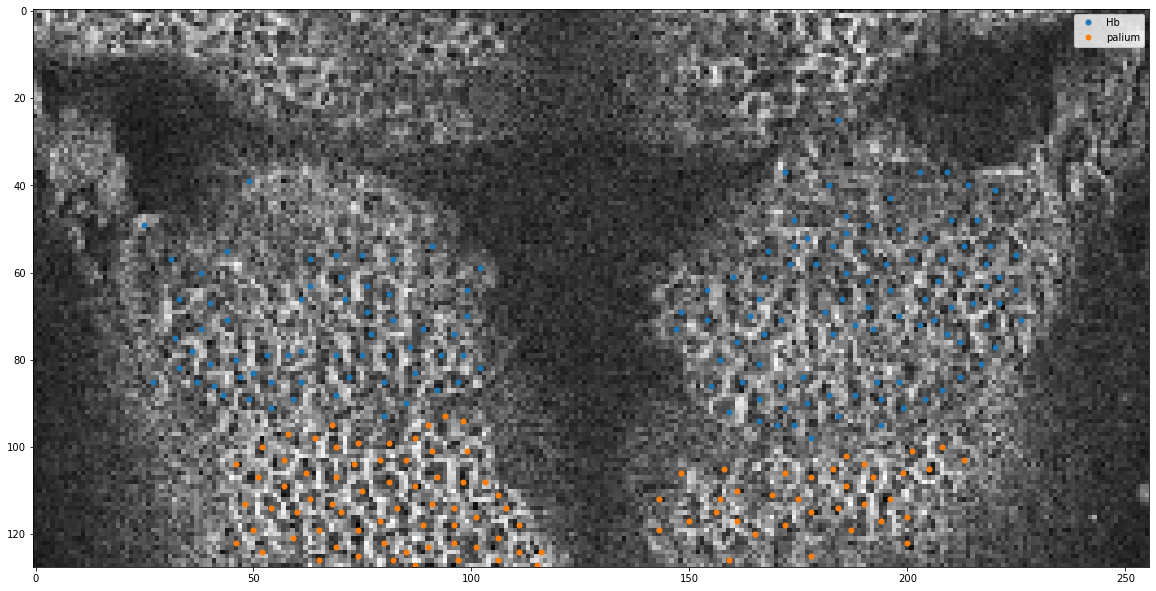

73-1


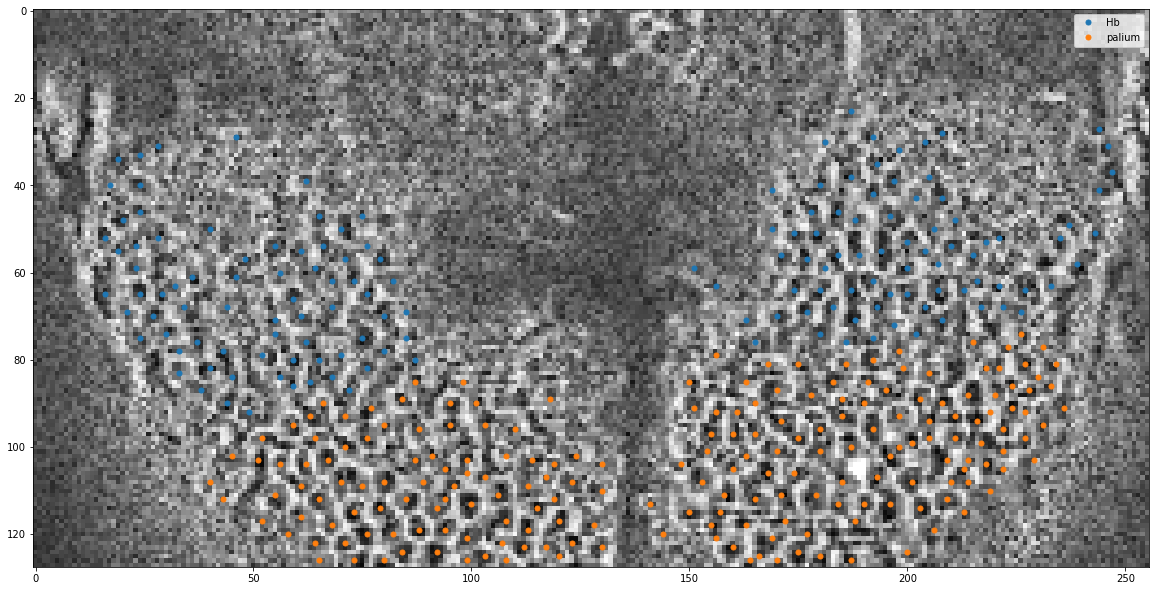

In [33]:
for key in list(areas.keys())[:2]:
    
    print(key)
    area = areas[key]
    plt.figure(figsize=(20,20))
    plt.imshow(cv2.resize(areas[key].template , (256, 128)), cmap='gray')
    for subarea in area.centers_small:
        centers_small = area.centers_small[subarea]
        plt.plot(centers_small[:,0], centers_small[:,1], "o", label = subarea, markersize=5)
    area.polygons_per_area_small
    plt.legend()
    plt.show()

In [34]:
def get_linear_fn(x1, y1, x2, y2):
    
    if x1 == x2:
        return x1, None
    
    a = (y2 - y1)/(x2 - x1)
    
    b = y1 - a*x1
    
    return a, b

for key in areas:
    area = areas[key]
    a, b = get_linear_fn(area.midline_points[0][0], area.midline_points[0][1], area.midline_points[1][0], area.midline_points[1][1])
    
    print(area.midline_points, a, b)
    
#     plt.imshow(area.template, cmap="gray")
#     plt.plot(area.midline_points[0][0], area.midline_points[0][1], "x",color="pink")
#     plt.plot(area.midline_points[1][0], area.midline_points[1][1], "x",color="pink")
#     plt.plot([area.midline_points[0][0], area.midline_points[1][0]],
#              [a*area.midline_points[0][0]+b, a*area.midline_points[1][0]+b], "-", color="green")
#     plt.show()
    
    area.grid_lefties = {}
    
    for region in area.grids:
        grid_centers_x = area.grids[region][:,0] + (area.grids[region][:,2] - area.grids[region][:,0])/2
        grid_centers_y = area.grids[region][:,1] + (area.grids[region][:,3] - area.grids[region][:,1])/2
        centers = np.array([grid_centers_x, grid_centers_y]).T * area.factor
        
        if b is not None:
            if a > 0:
                area.grid_lefties[region] = centers[:,1] > centers[:,0]*a + b
            else:
                area.grid_lefties[region] = centers[:,1] < centers[:,0]*a + b
        else:
            area.grid_lefties[region] = centers[:,0] < a

    area.roi_lefties = {}
    
    for region in area.centers:
        if b is not None:
            if a > 0:
                area.roi_lefties[region] = area.centers[region][:,1] > area.centers[region][:,0]*a + b
            else:
                area.roi_lefties[region] = area.centers[region][:,1] < area.centers[region][:,0]*a + b
        else:
            area.roi_lefties[region] = area.centers[region][:,0] < a

[(515, 8), (511, 508)] -125.0 64383.0
[(539, 507), (523, 6)] 31.3125 -16370.4375
[(516, 507), (504, 1)] 42.166666666666664 -21251.0
[(518, 508), (514, 0)] 127.0 -65278.0
[(560, 505), (553, 3)] 71.71428571428571 -39655.0
[(539, 1), (580, 508)] 12.365853658536585 -6664.195121951219
[(544, 504), (547, 2)] -167.33333333333334 91533.33333333334
[(515, 4), (526, 512)] 46.18181818181818 -23779.636363636364
[(517, 508), (523, 0)] -84.66666666666667 44280.66666666667
[(478, 507), (506, 4)] -17.964285714285715 9093.928571428572
[(555, 505), (544, 3)] 45.63636363636363 -24823.181818181816
[(519, 508), (509, 1)] 50.7 -25805.300000000003
[(522, 508), (532, 6)] -50.2 26712.4
[(628, 453), (495, 20)] 3.255639097744361 -1591.5413533834587
[(507, 507), (492, 2)] 33.666666666666664 -16562.0
[(540, 501), (523, 3)] 29.294117647058822 -15317.823529411764
[(518, 505), (517, 1)] 504.0 -260567.0
[(536, 504), (532, 2)] 125.5 -66764.0
[(506, 507), (505, 4)] 503.0 -254011.0
[(535, 506), (528, 4)] 71.7142857142857

In [ ]:
os.chdir(r'C:\Users\PC\Desktop\Analisis conf\PKL 03-2025')

In [35]:
for key in areas:
    save_area(r'C:\Users\PC\Desktop\Analisis conf\PKL 03-2025', key, areas[key])
    # print(areas_dir, key, areas[key])